In [1]:
import os
import numpy as np

from obspy import UTCDateTime, Stream, read
from pandas import read_pickle

import matplotlib.pyplot as plt

import sys
sys.path.append('../')

In [2]:
def __smooth(y, npts, win="hanning", setpad=True):

    from numpy import ones, convolve, hanning, nan, pad

    if win == "hanning":
        win = hanning(npts)
    elif win == "boxcar":
        win = ones(npts)

    if setpad:
        y = pad(y, npts, mode="edge")

    y_smooth = convolve(y, win/sum(win), mode='same')

    if setpad:
        y_smooth = y_smooth[npts:-npts]

    return y_smooth

In [3]:
def __reduce(dat, n_samples):
    from numpy import nanmean, isnan
    _dat = dat[~isnan(dat)]
    return dat - nanmean(_dat[:n_samples])

In [4]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/ontap-ffb-bay200/'
    lamont_path = '/home/andbro/lamont/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/import/ontap-ffb-bay200/'
    lamont_path = '/lamont/'
elif os.uname().nodename in ['lin-ffb-01', 'ambrym', 'hochfelln']:
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/import/ontap-ffb-bay200/'
    lamont_path = '/lamont/'

In [5]:
config = {}

# experiment 4
config['date1'] = "2024-03-09"
config['date2'] = "2024-05-21"

# specify path to data
config['path_to_data'] = data_path+"manuscripts/manuscript_romy_drifts/data/"

# specify path to store figures
config['path_to_figures'] = data_path+"manuscripts/manuscript_romy_drifts/figures/"


### Load MLTI Data

In [6]:
mlti = read_pickle(config['path_to_data']+f"bw_ru_longterm_mlti.pkl")

### Load Beam Walk Data

In [7]:
df = read_pickle(config['path_to_data']+f"bw_ru_longterm.pkl")

### Load Maintenance Log

In [8]:
lxx = read_pickle(config['path_to_data']+f"bw_ru_longterm_lxx.pkl")

### Load PROMY Temperature Data

In [9]:
ps = read(config['path_to_data']+"bw_ru_longterm_promy.mseed")

In [10]:
for tr in ps:
    tr.data = __smooth(__reduce(tr.data, 100), 3600)

ps_sum = Stream()
ps_sum = ps[0].copy()

ps_sum.data = np.zeros(len(ps_sum.data))

for tr in ps:
    ps_sum.data += tr.data


### Load FFBI Pressure Data

In [11]:
ffbi = read(config['path_to_data']+"bw_ru_longterm_ffbi.mseed")

### Plotting

In [12]:
def __makeplot_parameters():

    Nrow, Ncol = 7, 1

    font = 12
    size = 2
    tscale = 1/86400

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 10), sharex=True)

    # ax[0].fill_between(df.time_sec*tscale, df.x-df.x_var, df.x+df.x_var,
    #                    color="grey", alpha=0.7, interpolate=False
    #                   )
    ax[0].scatter(df.time_sec*tscale, df.x, s=size, zorder=2, color="k")
    ax[0].set_ylim(3.42, 3.8)
    ax[0].set_ylabel("X position")

    # ax[1].fill_between(df.time_sec*tscale, df.y-df.y_var, df.y+df.y_var,
    #                    color="grey", alpha=0.7, interpolate=False
    #                   )
    ax[1].scatter(df.time_sec*tscale, df.y, s=size, zorder=2, color="k")
    ax[1].set_ylim(1.57, 1.69)
    ax[1].set_ylabel("Y position")

    # ax[2].fill_between(df.time_sec*tscale, df.amp-df.amp_var, df.amp+df.amp_var,
    #                    color="grey", alpha=0.7, interpolate=False
    #                   )
    ax[2].scatter(df.time_sec*tscale, df.amp, s=size, zorder=2, color="k")
    ax[2].set_ylim(50, 130)
    ax[2].set_ylabel("Intensity")

    # ax[3].fill_between(df.time_sec*tscale, df.x_sig-df.x_sig_var, df.x_sig+df.x_sig_var,
    #                    color="grey", alpha=0.7, interpolate=False
    #                   )
    ax[3].scatter(df.time_sec*tscale, df.x_sig, s=size, zorder=2, color="k")
    ax[3].set_ylim(480, 520)
    ax[3].set_ylabel("Sigma X")

    # ax[4].fill_between(df.time_sec*tscale, df.y_sig-df.y_sig_var, df.y_sig+df.y_sig_var,
    #                    color="grey", alpha=0.7, interpolate=False
    #                   )
    ax[4].scatter(df.time_sec*tscale, df.y_sig, s=size, zorder=2, color="k")
    ax[4].set_ylim(480, 530)
    ax[4].set_ylabel("Sigma Y")

    # ax[5].fill_between(df.time_sec*tscale, df.theta-df.theta_var, df.theta+df.theta_var,
    #                    color="grey", alpha=0.7, interpolate=False
    #                   )
    ax[5].scatter(df.time_sec*tscale, df.theta, s=size, zorder=2, color="k")
    ax[5].set_ylim(0.1, 2.2)
    ax[5].set_ylabel("Theta")

    # ax[6].fill_between(df.time_sec*tscale, df.offset-df.offset_var, df.offset+df.offset_var,
    #                    color="grey", alpha=0.7, interpolate=False
    #                   )
    ax[6].scatter(df.time_sec*tscale, df.offset, s=size, zorder=2, color="k")
    ax[6].set_ylim(6.5, 12.5)
    ax[6].set_ylabel("Offset")

    ax[6].set_xlabel("Time (days)")

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        # ax[_n].legend(loc=1)

    plt.show();
    return fig

# fig = __makeplot_parameters();


In [13]:
def __makeplot_beam_wander(df0):

    import matplotlib.pyplot as plt
    from matplotlib.gridspec import GridSpec
    from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

    time_scaling = 1/86400

    Ncol, Nrow = 2, 6

    font = 12

    fig = plt.figure(figsize=(8, 12))

    gs1 = GridSpec(Nrow, Ncol, figure=fig, hspace=0.7)
    gs2 = GridSpec(Nrow, Ncol, figure=fig)

    ax1 = fig.add_subplot(gs1[0:3, :])

    ax2 = fig.add_subplot(gs2[3, :])
    ax3 = fig.add_subplot(gs2[4, :])

    plt.subplots_adjust(hspace=0.25)

    # ax1.scatter(df0.x_idx, df0.y_idx, c=df0.time_sec*time_scaling, s=5, zorder=2)
    # cb = ax1.scatter(df0.x, df0.y, c=df0.time_sec*time_scaling, s=5, zorder=2)
    cb = ax1.scatter(df0.x_um_rel, df0.y_um_rel, c=df0.time_sec*time_scaling, s=3, zorder=2)

    # ax2.scatter(df0.time_sec*time_scaling, df0.y, c=df0.time_sec*time_scaling, s=5, zorder=2)
    # ax3.scatter(df0.time_sec*time_scaling, df0.x, c=df0.time_sec*time_scaling, s=5, zorder=2)
    ax2.scatter(df0.time_sec*time_scaling, df0.y_um_rel, c=df0.time_sec*time_scaling, s=5, zorder=2)
    ax3.scatter(df0.time_sec*time_scaling, df0.x_um_rel, c=df0.time_sec*time_scaling, s=5, zorder=2)

    ax1.set_ylabel("rel. Y-Position ($\mu$m)")
    ax1.set_xlabel("rel. X-Position ($\mu$m)")

    ax2.set_ylabel("rel. X Position ($\mu$m)")
    # ax2.set_xlabel(f"Time (days) from {str(df.time_utc.iloc[0])[:10]}")

    ax3.set_ylabel("rel. X-Position  ($\mu$m)")
    ax3.set_xlabel(f"Time (days) from {str(df.time_utc.iloc[0])[:10]}")

    for ax in [ax1, ax2, ax3]:
        ax.grid(ls=":", alpha=0.5, zorder=0)

    for ax in [ax2, ax3]:
        ax.set_xlim(left=0)
        ax.xaxis.set_major_locator(MultipleLocator(5))
        ax.xaxis.set_minor_locator(MultipleLocator(1))

    # x1, x2 = 3.44, 3.52
    # y1, y2 = 1.62, 1.66
    x1, x2 = -20, 350
    y1, y2 = -50, 100
    ax1.set_xlim(x1, x2)
    ax1.set_ylim(y1, y2)
    ax2.set_ylim(y1, y2)
    ax3.set_ylim(x1, x2)

    # add title
    ax1.set_title(f"Beam Wander - North Ring (NW) [ {df0.time_utc.iloc[0].date} - {df0.time_utc.iloc[-1].date} ]", fontsize=font+1)

    # add colorbar
    cax1 = ax1.inset_axes([0.08, 0.86, 0.4, 0.02])
    cb5 = plt.colorbar(cb, ax=ax1, cax=cax1, orientation="horizontal")
    cb5.set_label(f"Time from {df0.time_utc.iloc[0].date} (days)", fontsize=font, labelpad=-40)

    # add maintencane periods
    ref_date = config['date1']
    for ax in [ax2, ax3]:
        for lx1, lx2 in zip(lxx.t1, lxx.t2):
            lx1_sec = lx1-UTCDateTime(ref_date)
            lx2_sec = lx2-UTCDateTime(ref_date)
            ax.fill_betweenx([-1000, 1000], lx1_sec*time_scaling, lx2_sec*time_scaling, color="yellow", alpha=0.3)

    axes = [ax1, ax2, ax3]
    for _k, (ax, ll) in enumerate(zip(axes, ['(a)', '(b)', '(c)'])):
        ax.text(.005, .97, ll, ha='left', va='top', transform=ax.transAxes, fontsize=font+2)


    plt.show();
    return fig

# fig = __makeplot_beam_wander(df)


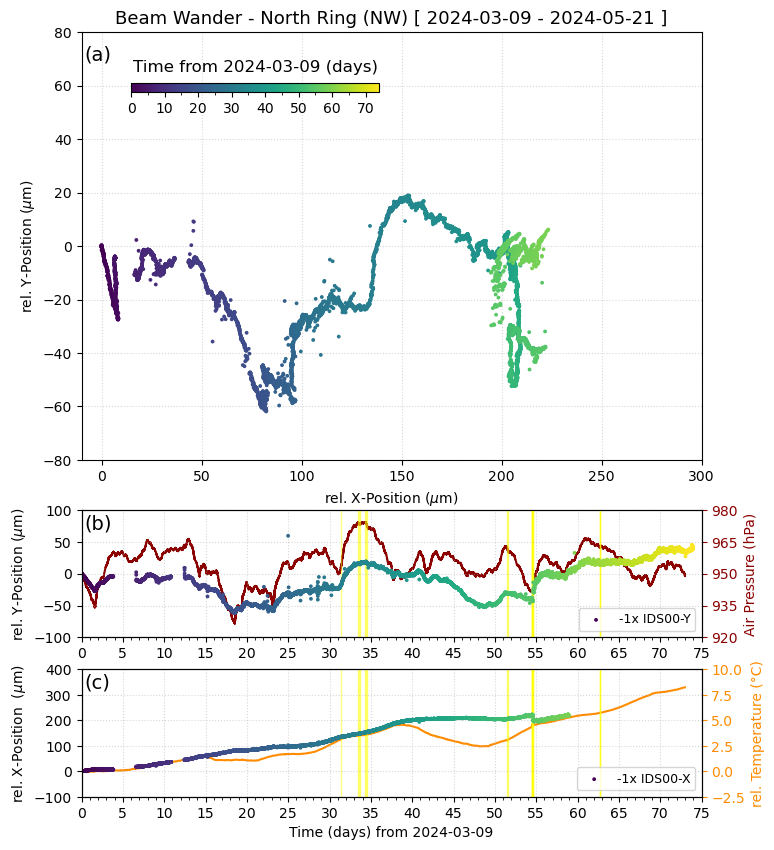

In [14]:
def __makeplot_beam_wander(df0):

    import matplotlib.pyplot as plt
    from matplotlib.gridspec import GridSpec
    from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

    time_scaling = 1/86400

    ref_date = config['date1']

    Ncol, Nrow = 2, 6

    font = 12

    fig = plt.figure(figsize=(8, 12))

    gs1 = GridSpec(Nrow, Ncol, figure=fig, hspace=0.7)
    gs2 = GridSpec(Nrow, Ncol, figure=fig)

    ax1 = fig.add_subplot(gs1[0:3, :])

    ax2 = fig.add_subplot(gs2[3, :])
    ax3 = fig.add_subplot(gs2[4, :])

    plt.subplots_adjust(hspace=0.25)

    cb = ax1.scatter(-1*df0.x_um_rel, -1*df0.y_um_rel, c=df0.time_sec*time_scaling, s=3, zorder=2)

    ax2.scatter(df0.time_sec*time_scaling, -1*df0.y_um_rel, c=df0.time_sec*time_scaling,
                label="-1x IDS00-Y", s=3, zorder=2)

    ax3.scatter(df0.time_sec*time_scaling, -1*df0.x_um_rel, c=df0.time_sec*time_scaling,
                label="-1x IDS00-X", s=3, zorder=2)

    # add pressure
    ax222 = ax2.twinx()
    ax222.plot(ffbi.select(channel="*O")[0].times(reftime=UTCDateTime(ref_date))*time_scaling,
               ffbi.select(channel="*O")[0].data, color="darkred"
              )

    ax222.tick_params(axis='y', colors="darkred")
    ax222.set_ylabel("Air Pressure (hPa)", color="darkred")
    # ax222.invert_yaxis()

    ax1.set_ylabel("rel. Y-Position ($\mu$m)")
    ax1.set_xlabel("rel. X-Position ($\mu$m)")

    # add temperature
    ax333 = ax3.twinx()
    ax333.plot(ps_sum.times(reftime=UTCDateTime(config['date1']))*time_scaling,
               ps_sum.data, color="darkorange"
              )

    ax333.tick_params(axis='y', colors="darkorange")
    ax333.set_ylabel("rel. Temperature (°C)", color="darkorange")

    # _________________________________________________________

    ax2.set_ylabel("rel. Y-Position ($\mu$m)")
    ax3.set_ylabel("rel. X-Position  ($\mu$m)")
    ax3.set_xlabel(f"Time (days) from {str(df.time_utc.iloc[0])[:10]}")

    for ax in [ax1, ax2, ax3]:
        ax.grid(ls=":", alpha=0.5, zorder=0)

    for ax in [ax2, ax3]:
        ax.set_xlim(0, 75)
        ax.xaxis.set_major_locator(MultipleLocator(5))
        ax.xaxis.set_minor_locator(MultipleLocator(1))

        _, _ , _ymin, _ymax = ax.axis()

        # add maintenance
        ref_date = config['date1']
        for lx1, lx2 in zip(lxx.t1, lxx.t2):
            lx1_sec = lx1-UTCDateTime(ref_date)
            lx2_sec = lx2-UTCDateTime(ref_date)
            ax.fill_betweenx([_ymin*2, _ymax*2], lx1_sec*time_scaling, lx2_sec*time_scaling, color="yellow", alpha=0.5)

    ax1.set_xlim(-10, 300)
    ax1.set_ylim(-80, 80)
    ax2.set_ylim(-80, 60)
    ax3.set_ylim(-10, 350)

    ax2.legend(loc=4, fontsize=font-3)
    ax3.legend(loc=4, fontsize=font-3)

    ax2.set_yticks(np.linspace(ax2.get_yticks()[0], ax2.get_yticks()[-1], len(ax2.get_yticks())))
    ax222.set_yticks(np.linspace(ax222.get_yticks()[0], ax222.get_yticks()[-1], len(ax2.get_yticks())))
    ax2.set_zorder(10)
    ax2.patch.set_visible(False)

    ax3.set_yticks(np.linspace(ax3.get_yticks()[0], ax3.get_yticks()[-1], len(ax3.get_yticks())))
    ax333.set_yticks(np.linspace(ax333.get_yticks()[0], ax333.get_yticks()[-1], len(ax3.get_yticks())))
    ax3.set_zorder(10)
    ax3.patch.set_visible(False)

    # add title
    ax1.set_title(f"Beam Wander - North Ring (NW) [ {df0.time_utc.iloc[0].date} - {df0.time_utc.iloc[-1].date} ]", fontsize=font+1)

    # add colorbar
    cax1 = ax1.inset_axes([0.08, 0.86, 0.4, 0.02])
    cb5 = plt.colorbar(cb, ax=ax1, cax=cax1, orientation="horizontal")
    cb5.set_label(f"Time from {df0.time_utc.iloc[0].date} (days)", fontsize=font, labelpad=-40)
    cax1.xaxis.set_major_locator(MultipleLocator(10))
    cax1.xaxis.set_minor_locator(MultipleLocator(5))

#     # add maintencane periods
#     for ax in [ax2, ax3]:
#         _, _ , _ymin, _ymax = ax.axis()

#         # add maintenance
#         for lx1, lx2 in zip(lxx.t1, lxx.t2):
#             lx1_sec = lx1-UTCDateTime(ref_date)
#             lx2_sec = lx2-UTCDateTime(ref_date)
#             ax.fill_betweenx([_ymin, _ymax], lx1_sec*time_scaling, lx2_sec*time_scaling, color="yellow", alpha=0.5)

    # add subplot labels
    axes = [ax1, ax2, ax3]
    for _k, (ax, ll) in enumerate(zip(axes, ['(a)', '(b)', '(c)'])):
        ax.text(.005, .97, ll, ha='left', va='top', transform=ax.transAxes, fontsize=font+2)

    plt.show();
    return fig

fig = __makeplot_beam_wander(df)

fig.savefig(config['path_to_figures']+f"BW_RU_longterm_{config['date1']}_{config['date2']}.png",
            format="png", dpi=150, bbox_inches='tight'
           )
